# Analysis of FastMap Algorithm on Directed Graph

The content of this analysis includes:

1. Dataset - testing graph:
    - Generated random graph
    - Some directed networks from [Stanford Large Network Dataset Collection (SNAP)](https://snap.stanford.edu/data/)
2. Variant of FastMap on directed graph:
    - Two embeddings:
        1. $h_1(i, j)=\frac{d_{ij}+d_{ji}}{2}$
        2. $h_2(i, j)=\frac{|d_{ij}-d_{ji}|}{2}$
    - Part accurate distances: a byproduct, every nodes' distances with some pivot nodes
3. Evaluation:
    - Precision of picking the bigger one of $d_{ij}$ and $d_{ji}$, using stroed distances
    - Distortion of embedding:
        1. Using real comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
        2. Using prediction of comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
        3. Using stroed distances to fine-tune heuristic value from embedding.
4. Experiments and results

In [1]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../heuristic/'))
sys.path.append(lib_path)

import fastmap.utils as utils
from fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff 
import fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random

## Generate random testing graph:

1. `generate_random_digraph(n, p, low, high)`: generate a directed graph with `n` nodes, and every edge have positive weith range in `[low, high]`, it make sure the graph is strongly connected, otherwise there is a warning for increasing `p` (the probability of an directed edge exist between two nodes). Density $D = \frac{|E|}{|V|(|V|-1)}$ is also printed.

2. `distance_info(G)`: show the distribution of distances between nodes.

In [18]:
def generate_random_digraph(n, p, low, high):
    for i in range(100):
        G = nx.gnp_random_graph(n, p, directed = True)
        if nx.is_strongly_connected(G):
            break
    if nx.is_strongly_connected(G) == False:
        print("Unable to generate strongly connected graph, try increase 'p'.")
    density = float(len(G.edges()))/(n*(n-1))
    print("Density: {}".format(density))
    for (n1, n2) in G.edges():
        G[n1][n2]['weight']=random.randint(low, high)
    return G, density

def distance_info(G):
    dis = []
    for node in list(G.nodes()):
        length = nx.single_source_dijkstra_path_length(G, node)
        dis.extend(list(length.values()))
    x = list(set(dis))
    y = []
    for i in x:
        y.append(dis.count(i))
    y[0]=0
    s = sum(y)
    for i in range(len(y)):
        y[i] = float(y[i])/s
    plt.plot(x,y,'r-o', linewidth=1)
    plt.xlabel('distance')
    plt.ylabel('count (persents)')
    plt.title('Statistic of pair distances')
    plt.show()

An example:

Density: 0.007018018018018018


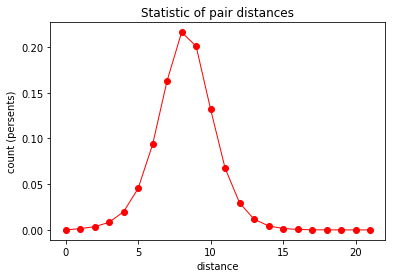

In [19]:
n = 1000
p = 0.007
low = 1
high = 5

G,_ = generate_random_digraph(n, p, low, high)
distance_info(G)

## Variant algorithms of embedding

![Figure](alg-fastmap.png)

1. `init_dis_store()`: init the data structure to store every nodes' distances to pivot nodes, the store process will be finish while doing the embedding.

2. `difastmap_average(G, K, epsilon, dis_store, alg='L1')`: used to get the embedding of average distances.

3. `difastmap_diff(G, K, epsilon, dis_store, alg='L1')`: used to get the embedding of absolute difference of distance.

An example:

In [21]:
K = 20
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
embedding_diff = difastmap_diff(G, K, epsilon, dis_store, alg)
S = 1
subset = random.sample(list(G.nodes()), S)
for i in subset:
    print("Node {}:\n{}\n{}".format(i, embedding_aver[i], embedding_diff[i]))

Node 614:
[6.325, 8.042461608118403, 6.44658376595255, 6.479636442230581, 7.73458994599847, 7.772058097298405, 7.174728132219819, 7.233603101050599, 6.166457694005503, 5.588314172741528, 3.2053345106523268, 6.824782388628141, 6.44780240911064, 5.824723252576411, 4.5434089176598365, 6.423447739583986, 6.409712750561176, 5.924582333014045, 7.5058258144492775, 4.846270179392789]
[3.2045454545454546, 2.4830983944420693, 1.7769330636610294, 2.703634453903815, 2.034123409741144, 2.688250122476972, 2.2667709351357415, 2.2021147569161164, 3.415484867996177, 2.6139967992568534, 2.2112131904684733, 2.1600702485014285, 3.1213915108414154, 3.22109389942683, 1.7224289305848648, 1.7372680917256171, 3.631318738973803, 2.2521545629129176, 2.3791793228127753, 2.1168648208533223]


## Evaluation functions

`dinrmsd(G, embedding_aver, embedding_diff, dis_store, S, alg = 'L1')`: the function for evaluate the performance of the heuristic. `S` is the number of subset choosed for evaluation, and the `alg` should be set as the one used in FastMap embedding.

The output has four value:

- Precision of comparing $d_{ij}$, $d_{ji}$
- Distortion when:
    - Real comparision
    - Predicted comparision
    - Fine-tuned distance
    
Using the Normalized Root Mean Square Deviation (NRMSD):
$$\sigma = \sqrt{\frac{\sum_{1\le i < j\le S}{(d_{ij}-x_{ij})^2}}{S(S-1)}}$$
$$\bar{d}=\frac{\sum_{1\le i < j\le S}{d_{ij}}}{S(S-1)}$$

In [34]:
S = int(0.2*len(list(G.nodes())))
results = analyse.dinrmsd(G, embedding_aver, embedding_diff,dis_store, S, alg)
print("\nPrecision: "+str(results[0]))
print("Distortion_real: "+ str(results[1]))
print("Distortion_pred: "+ str(results[2]))
print("Distortion_tune: "+ str(results[3]))

Analysis Process: 0.0%
Precision: 0.7421052631578947
Distortion_real: 0.2775127004423273
Distortion_pred: 0.32448200134466887
Distortion_tune: 0.25130986069654365


## Experiments